## Visualize WoFCast Predictions

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# Set this lower, to allow for PyTorch Model to fit into memory
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95' 
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys, os 
package_path = os.path.dirname(os.path.dirname(os.getcwd())) 
print(f'{package_path=}')
sys.path.insert(0, package_path)
from glob import glob 

from wofscast.model import WoFSCastModel
from wofscast.data_generator import (load_chunk, 
                                     dataset_to_input, 
                                     add_local_solar_time, 
                                     DataAssimDataLoader
                                    )
                                     
                                     
from wofscast.common.wofs_data_loader import WoFSDataLoader
from wofscast.common.wofs_analysis_loader import WoFSAnalysisLoader

# For the diffusion model. 
from wofscast.diffusion import DiffusionModel 

# Utils for loading data, plotting, animations. 
from wofscast.common.mrms_data_loader import MRMSDataLoader 
from wofscast.common.helpers import (get_case_date, 
                                     to_datetimes, 
                                     get_qpe_datetimes, 
                                     border_difference_check,
                                     compute_nmep, 
                                     convert_rain_amount_to_inches, 
                                     convert_T2_K_to_F
                                    ) 
from wofscast.common.plot_utils import WoFSCastAnimator 
from dataclasses import dataclass

# To display the animation in a Jupyter notebook
from IPython.display import HTML

# For plotting. 
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

package_path='/home/monte.flora/python_packages/frdd-wofs-cast'


In [2]:
import matplotlib.colors as mcolors
# For plotting. 
import os
import numpy as np
import xarray 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wofscast.plot import WoFSColors, WoFSLevels
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr

display_name_mapper = {'U' : 'U-wind Comp.', 
          'V' : 'V-wind Comp.', 
          'W' : 'Vert. Velocity',
          'T' : 'Pot. Temp.', 
          'GEOPOT' : 'Geopot. Height',
          'QVAPOR' : 'QVAPOR', 
          'T2' : '2-m Temp.', 
          'COMPOSITE_REFL_10CM' : 'Comp. Refl.',
          'UP_HELI_MAX' : '2-5 km UH', 
          'RAIN_AMOUNT' : 'Rain Rate',
          'WMAX' : 'Max Vert. Velocity',
         }

units_mapper = {'T': 'K', 
                'QVAPOR': 'kg/kg', 
                'T2': 'F', 
                'U': 'm/s', 
                'V': 'm/s', 
                'W': 'm/s', 
                'GEOPOT': 'm', 
                'RAIN_AMOUNT': 'in', 
                'COMPOSITE_REFL_10CM': 'dBZ',
                'WMAX' : 'm/s'
               }

VARS_2D = ['COMPOSITE_REFL_10CM', 
           'T2', 
           'RAIN_AMOUNT'
          ]

class Animator:
    
    CMAPS = {
        'COMPOSITE_REFL_10CM': WoFSColors.nws_dz_cmap,
        'RAIN_AMOUNT' : WoFSColors.rain_cmap,
        'UP_HELI_MAX' : WoFSColors.wz_cmap_extend,
        'T2' : WoFSColors.temp_cmap,
        'QVAPOR' : WoFSColors.temp_cmap,
        'W' : WoFSColors.wz_cmap_extend,
        'WMAX' : WoFSColors.wz_cmap_extend
    }
    
    DEFAULT_CMAP = WoFSColors.wz_cmap_extend
    #RANDY_CMAP = 
    
    LEVELS = {
        'COMPOSITE_REFL_10CM' : WoFSLevels.dz_levels_nws,
        'RAIN_AMOUNT' : WoFSLevels.rain_rate_levels,
        'UP_HELI_MAX' : WoFSLevels.uh_2to5_levels_3000m,
        'T2' : np.arange(40, 90, 2.5),
        'QVAPOR' : WoFSColors.temp_cmap,
        'W' : [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20],
        'WMAX': [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]
    }
    
    
    def __init__(self, 
                 forecast, 
                 truth, 
                 mrms_dataset, 
                 analysis_dataset,
                 add_rmse=True, 
                 add_mrms_overlay = True,
                 for_randy=False,
                 add_wind_barbs = False
                ):
        
        self.add_rmse = add_rmse 
        self.for_randy = for_randy
        self.add_wind_barbs = add_wind_barbs
        self.datasets = {
            'WoFS' : truth,
            'WoFSCast' : forecast,
            'Analysis' : analysis_dataset, 
            'MRMS' : mrms_dataset,
        }
        
        self.add_mrms_overlay = add_mrms_overlay
        self.dts = self.datasets['WoFSCast'].datetime.values  
    
    def animate(self, variables, level=0, ens_idx=0, animation_type='wofs_vs_wofscast'):
        """
        Generalized function to create different types of animations based on the animation_type.
        
        Parameters:
        - variables: Variable(s) to animate.
        - level: Vertical level to animate.
        - animation_type: Type of animation ('wofs_vs_wofscast' or 'wofs_wofscast_analysis_mrms').
        
        Returns:
        - FuncAnimation object.
        """
        self.animation_type = animation_type
        self.variables = variables
        level_txt = self.set_level(var, level)
        self.ens_idx = ens_idx 
        
        if animation_type == 'wofs_vs_wofscast':
            fig, self.axes = plt.subplots(dpi=200, figsize=(12, 6), ncols=2, 
                                          gridspec_kw={'height_ratios': [1], 'bottom': 0.15})
        
        elif animation_type == 'wofs_wofscast_analysis_mrms':
            fig, self.axes = plt.subplots(dpi=200, figsize=(12, 12), nrows=2, ncols=2,
                                          gridspec_kw={'height_ratios': [1, 1], 'bottom': 0.1})
        
        plt.tight_layout()
        
        # Create a BoundaryNorm instance
        #self.norm = mcolors.BoundaryNorm(self.levels, ncolors=len(self.levels)-1, clip=True)
        
        self.cbar_ax = fig.add_axes([0.15, 0.075, 0.7, 0.02])
        self.cbar = None
        
        self.fig = fig
        self.N = len(self.datasets['WoFSCast'].time)
    
        return FuncAnimation(fig, self.update, frames=self.N, interval=200)

    def set_level(self, var, level):
        if isinstance(var, list):
            return ''

        if var in VARS_2D:
            level='none'
        
        self.level = level
        
        level_txt = ''
        if level != 'none': 
            level_txt = f', Sigma level = {level}'
            
        return level_txt
    
    def set_default_levels(self, data):
        global_min = np.percentile(data, 1)
        global_max = np.percentile(data, 99)
        rng = np.linspace(global_min, global_max, 10)
        return rng 
    
    def drop_batch_dim(self, ens_idx, dataset):
        dims = ('time', 'level', 'lat', 'lon')
         
        dataset = dataset.isel(batch=ens_idx)    
        dataset = dataset.transpose(*dims, missing_dims='ignore')

        return dataset
    
    def remove_ticks(self, ax):
        
        # Remove tick marks
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
            
        # Optionally, remove tick labels too
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    
        return ax
    
    def format_ax(self, ax, title):
        
        ax = self.remove_ticks(ax)
        ax.set_title(title, fontweight='bold')
        
        return ax
    
    def compute_rmse(self, forecast, truth):
        return np.sqrt(np.mean((forecast - truth)**2)).values 
    
    def get_z(self, dataset): 
                
        if self.level == 'max':
            data = dataset.max(dim='level')
        elif self.level == 'min':
            data = dataset.min(dim='level')
        elif isinstance(self.level,int):
            data = dataset.isel(level=self.level)
        else:
            data = dataset.copy(deep=True)
        
        return data.values 

    def get_time_idx(self, time_idx, dataset_name):
        
        if dataset_name != 'WoFSCast':
            # For rollouts longer than the 
            # times avaliable in the truth dataset, 
            # set the upper limit to max number of time steps. 
            max_t = len(self.datasets['WoFS'].time) - 1
            target_t = max_t
            if time_idx < max_t:
                target_t = time_idx
                
            return target_t
            
        return time_idx
        
    def add_rmse_annotation(self, ax, rmse):
        dis_name = display_name_mapper.get(self.variables, self.variables)
        ax.annotate(f'RMSE of {dis_name} ({units_mapper.get(self.variables, self.variables)}): {rmse:.4f}', 
                            xy=(0.01, 0.95), xycoords='axes fraction', 
                            weight='bold', color='red', 
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        return ax
    
    def get_cmap(self, var):
        return self.CMAPS.get(var, self.DEFAULT_CMAP)
    
    def get_levels(self, var):
        return self.LEVELS.get(var, None)
    
    
    def plot(self, ax, dataset):
        # T2 where dBZ < 35, green color fill for RAIN, red color fill for WMAX, 
        
        if self.variables == 'multiple_vars':
            variables = ['T2', 'COMPOSITE_REFL_10CM', 'RAIN_AMOUNT', 'WMAX']
            
            t2 = self.get_z(dataset['T2'])
            comp_dz = self.get_z(dataset['COMPOSITE_REFL_10CM'])
            
            rain = self.get_z(dataset['RAIN_AMOUNT'])
            wmax = self.get_z(dataset['WMAX'])
            
            # 1. Color fill T2, but for regions < 35 dBZ
            t2_masked = np.ma.masked_where(comp_dz > 35, t2)
            
            im = ax.contourf(t2_masked, origin='lower', aspect='equal', 
                        cmap='Spectral_r', 
                        levels=self.get_levels('T2'), 
                        alpha=0.95
                       )
            
            # 2. Color fill WMAX with Reds 
            #ax.contour(wmax, origin='lower', aspect='equal', 
            #            colors = ['red'], levels=[10.], linewidths=[1.5]
            #           )
            
            # 3. Color fill RAIN_AMOUNT with Greens 
            rain_masked = np.ma.masked_where(rain < 0.15, rain)
            ax.contourf(rain_masked, origin='lower', aspect='equal', 
                        cmap='Greens', 
                        levels=self.get_levels('RAIN_AMOUNT'), extend='max', 
                       )
            
            # 4. Comp. reflecivity contours 
            ax.contour(comp_dz, origin='lower', aspect='equal', 
                        levels=[35.], colors=['k'], linewidths = [2.0]
                       )

        else:
            cmap = self.CMAPS.get(self.variables, self.DEFAULT_CMAP)
            levels = self.LEVELS.get(self.variables, None)
            
            z = self.get_z(dataset[self.variables])
            
            if self.variables in ['REFL_10CM', 'UP_HELI_MAX', 'COMPOSITE_REFL_10CM']:
                z = np.ma.masked_where(z < 10, z)
                
            
            im = ax.contourf(z, origin='lower', aspect='equal', cmap=cmap, levels=levels)
    
            if self.add_wind_barbs: 
                x = np.arange(len(z))
                xx, yy = np.meshgrid(x,x)
            
                u,v = dataset['U'].isel(level=0).values, dataset.isel(level=0)['V'].values
                
                thin = 20
                ax.barbs(xx[::thin, ::thin], yy[::thin, ::thin], u[::thin, ::thin], v[::thin, ::thin]) 
                
        return im, ax 
    
    def add_time_annotation(self, ax, t):
        ax.annotate(f'Time: {self.dts[t]}', xy=(0.01, 0.01), xycoords='axes fraction', 
                        weight='bold', color='red', fontsize=10, 
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        return ax 
    
    def update(self, t):
        # Remove any previous plotted data or formatting. 
        for ax in self.axes.flat:
            ax.clear()

        if self.add_rmse:
            rmse = self.compute_rmse(self.datasets['WoFSCast'], self.datasets['WoFS'])
        
        ##print(f'{rmse=}')
        
        #default_dataset_rngs = self.set_default_levels(self, data)
        
        for i, (ax, (name, dataset)) in enumerate(zip(self.axes.flat, self.datasets.items())):
            
            title = name #f'{self.title_prefixes[0]} {display_name_mapper.get(var, var)}{level_txt}'
            ax = self.format_ax(ax, title)
            
            # Remove the batch dimension, if size==1
            dataset = self.drop_batch_dim(self.ens_idx, dataset)
            
            #t = self.get_time_idx(t, title)
            
            
            try:
                dataset_at_t = dataset.isel(time=t)
            except:
                dataset_at_t = dataset.isel(time=1)
            #dataset_up_to_t = dataset.isel(time=slice(0,t)).sum(dim='time')
            
            im, ax = self.plot(ax, dataset_at_t)

            if i == 1 and self.add_rmse:
                ax = self.add_rmse_annotation(ax, rmse)

            #ax = self.add_time_annotation(ax, t)

            #if self.add_mrms_overlay:
            #    self.mrms_overlay(ax, z[1], t)

        if self.cbar is None:
            self.cbar = self.fig.colorbar(im, cax=self.cbar_ax, orientation='horizontal')
            var = 'T2' if self.variables == 'multiple_vars' else self.variables 
            self.cbar.set_label(
                f'{display_name_mapper.get(var, var)} ({units_mapper.get(var, var)})')

    def mrms_overlay(self, ax, pred, t):
        this_rmse = np.sqrt(np.mean((pred - self.mrms_dataset[t]) ** 2))

        ax.contour(self.mrms_dataset[t], 
                   origin='lower', aspect='equal', 
                   colors=['black', 'blue'], 
                   levels=[35.0, 50.0], linewidths=[1.0, 1.5])
        
        if self.add_rmse:
            ax.annotate(f'RMSE with MRMS: {this_rmse:.4f}', 
                    xy=(0.01, 0.90), xycoords='axes fraction', 
                    weight='bold', color='k', 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


## Configuration for Plotting, Data loading, Model Loading

In [3]:
# This configuration class contains all the user-settings required to run this notebook. 
year = '2021'
# For the legacy v178 model.
base_path = '/work/mflora/wofs-cast-data/datasets_zarr/'

# NOTE: DO NOT SELECT MEM 09 AS THAT MEMBER IS THE 'CONTROL' MEMBER!!!!!!!!
#fname = 'wrfwof_2021-06-01_203000_to_2021-06-01_210000__10min__ens_mem_06.zarr'
#data_path = os.path.join(base_path, year, fname)

idx= 300
paths = glob(os.path.join(base_path, year, '*ens_mem_06.zarr'))
paths.sort()
data_path = paths[idx]

@dataclass
class VisualizationConfig :
    save_animations = True

    model_path = '/work/mflora/wofs-cast-data/model/wofscast_da_v8.npz'
    
    # Whether to load all ensemble members. 
    load_ensemble = False
    
    timestep = 10 
    steps_per_hour = 60 // timestep # 60 min / 5 min time steps
    hours = 2
    n_steps = int(steps_per_hour * hours)
    
    year = '2021'
    mem = 9 
    
    resize = False if 'full_domain' in data_path else True
    
    full_domain = True if 'full_domain' in data_path else False
    
    decode_times = True 
  
config = VisualizationConfig()
config.domain_size = 300 if config.full_domain else 150

preprocess_fn = add_local_solar_time
config.decode_times = False
additional_configs = {"legacy_mesh" : True, "loss_callable" : None}

In [4]:
data_path

'/work/mflora/wofs-cast-data/datasets_zarr/2021/wrfwof_2021-05-18_210000_to_2021-05-18_213000__10min__ens_mem_06.zarr'

## Generate WoFS-Cast Predictions 

In [5]:
model = WoFSCastModel()

if config.full_domain:
    model.load_model(config.model_path, **{'tiling' : (2,2)})
else:    
    model.load_model(config.model_path, **additional_configs)

In [11]:
%%time 
generator = DataAssimDataLoader(
        gauss_filter_size = 10, 
        known_variables = ['U', 'V', 'COMPOSITE_REFL_10CM', 'HGT', 'XLAND'],
        unknown_variables = ['W', 'T', 'GEOPOT', 'QVAPOR', 'RAIN_AMOUNT', 'T2'],
        skewed_variables = ['W', 'RAIN_AMOUNT'],
        paths = [data_path],
        batch_size=1, 
        task_config = model.task_config, 
        target_lead_times = '10min',
        num_devices=1, 
        decode_times = True
        )    

inputs, targets, forcings = generator.generate()    

predictions = model.predict(inputs, targets, forcings,) 
                            #initial_datetime=pd.to_datetime(inputs.isel(time=-1).datetime.values), 
                            #n_steps=config.n_steps,
#                            replace_bdry=False)

# 18-mem 2hr ensemble prediction on 1 GPU: 39.6 s 

CPU times: user 58.5 s, sys: 4.51 s, total: 1min 2s
Wall time: 7.5 s


In [12]:
predictions['WMAX'] = predictions['W'].max(dim='level')
inputs['WMAX'] = inputs['W'].max(dim='level')
targets['WMAX'] = targets['W'].max(dim='level')

predictions['QMAX'] = predictions['QVAPOR'].max(dim='level')
inputs['QMAX'] = inputs['QVAPOR'].max(dim='level')
targets['QMAX'] = targets['QVAPOR'].max(dim='level')

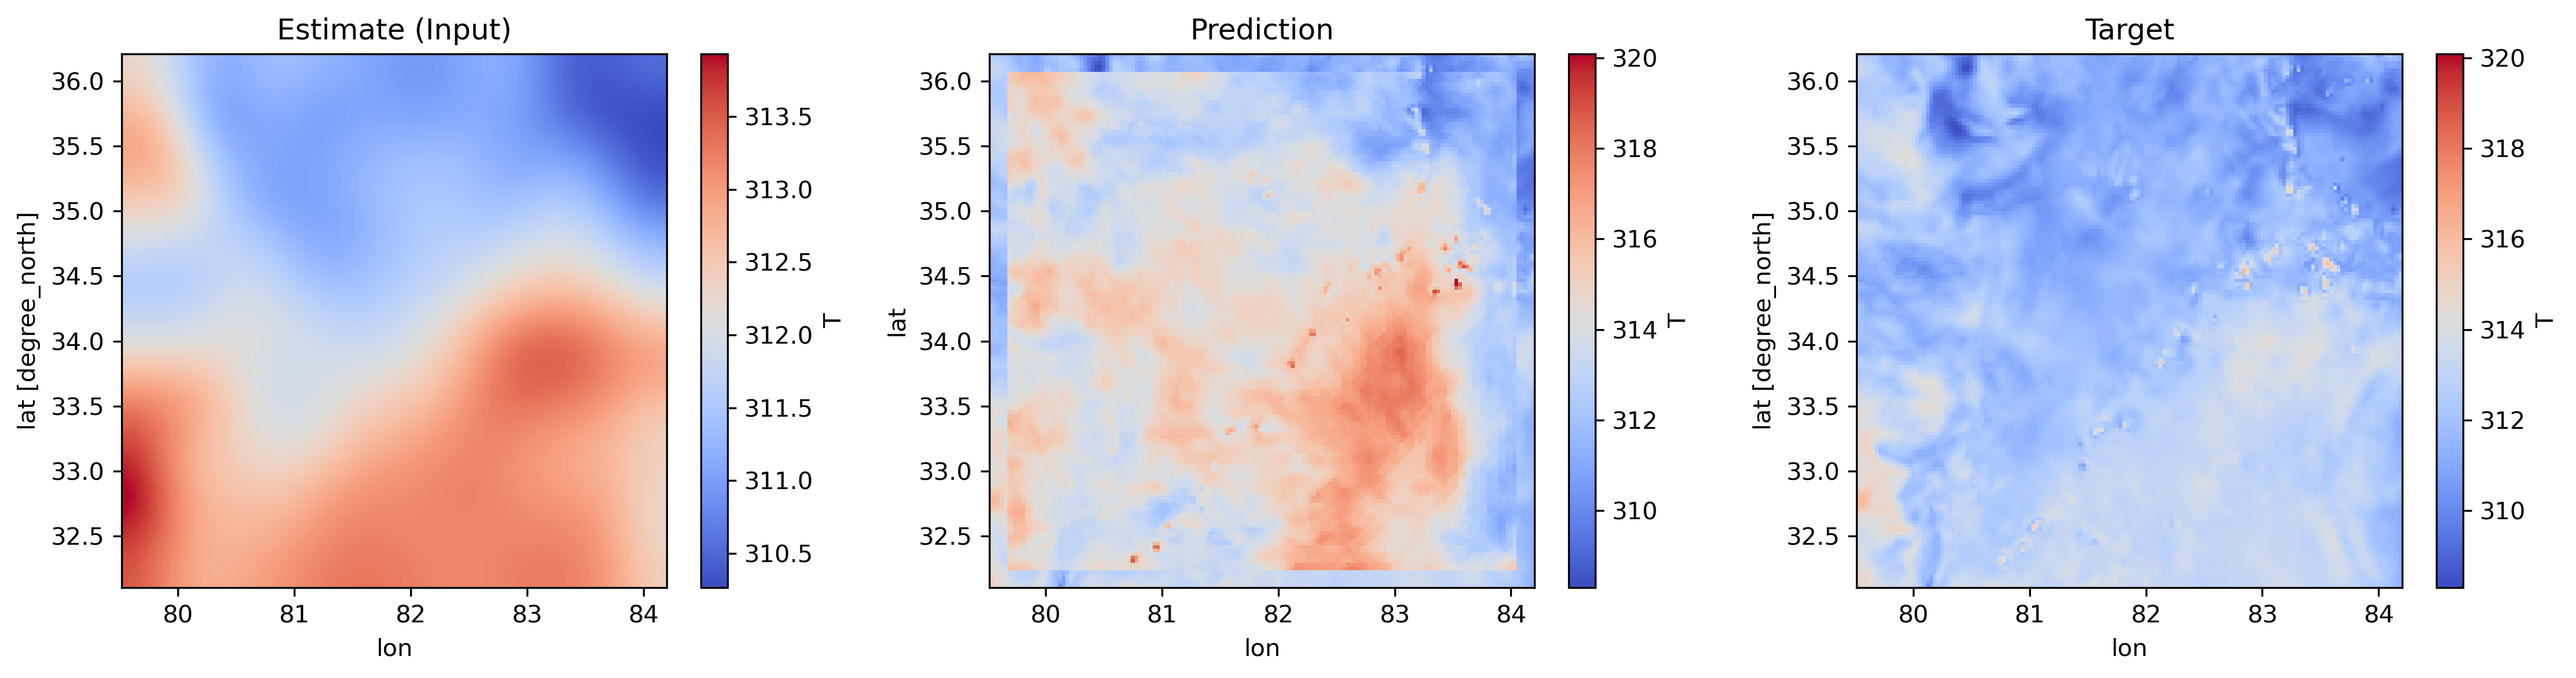

In [13]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

#cmap = 'gist_earth_r'
cmap = 'coolwarm'
var = 'T'
level = 5

vmin = min(
           #inputs.isel(batch=0, time=0, level=level)[var].min().item(),
           predictions.isel(batch=0, time=0, level=level)[var].min().item(),
           targets.isel(batch=0, time=0, level=level)[var].min().item())

vmax = max(
           #inputs.isel(batch=0, time=0, level=level)[var].max().item(),
           predictions.isel(batch=0, time=0, level=level)[var].max().item(),
           targets.isel(batch=0, time=0, level=level)[var].max().item())


# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0, level=level)[var].plot(ax=axes[0], cmap=cmap)#, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0, level=level)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0, level=level)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (Input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()

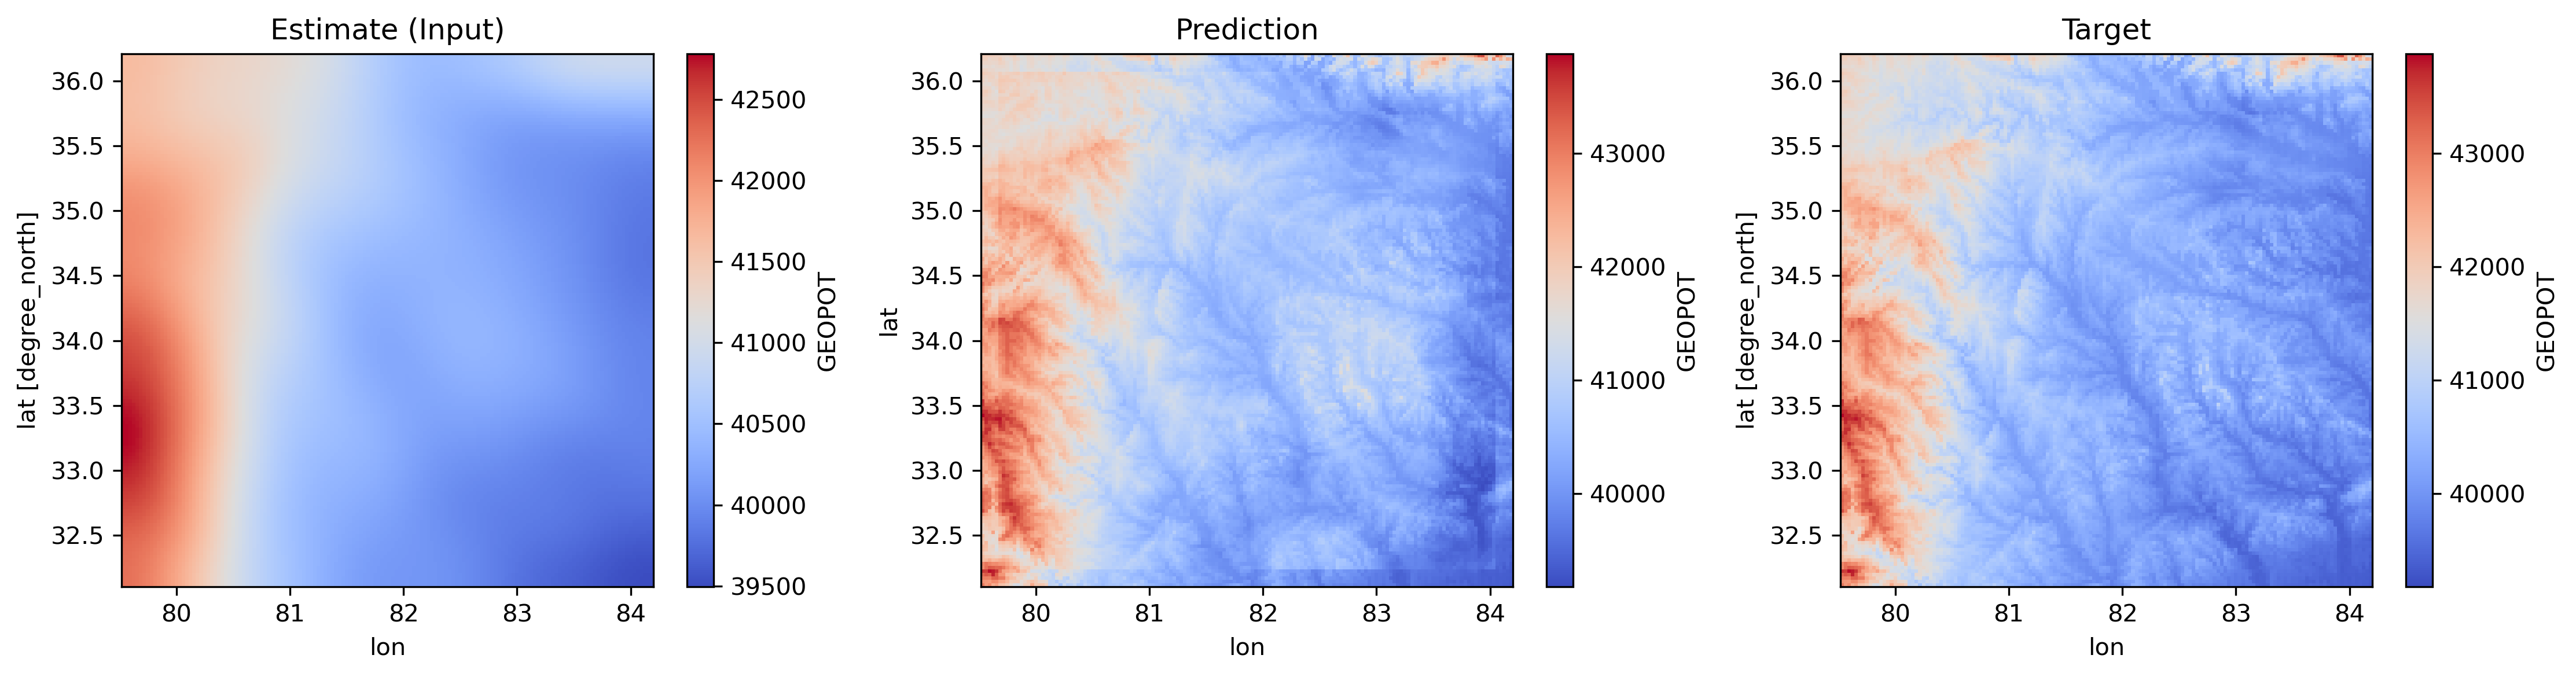

In [14]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

#cmap = 'gist_earth_r'
cmap = 'coolwarm'
var = 'GEOPOT'
level = 5

vmin = min(
           #inputs.isel(batch=0, time=0, level=level)[var].min().item(),
           predictions.isel(batch=0, time=0, level=level)[var].min().item(),
           targets.isel(batch=0, time=0, level=level)[var].min().item())

vmax = max(
           #inputs.isel(batch=0, time=0, level=level)[var].max().item(),
           predictions.isel(batch=0, time=0, level=level)[var].max().item(),
           targets.isel(batch=0, time=0, level=level)[var].max().item())


# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0, level=level)[var].plot(ax=axes[0], cmap=cmap)#, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0, level=level)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0, level=level)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (Input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()

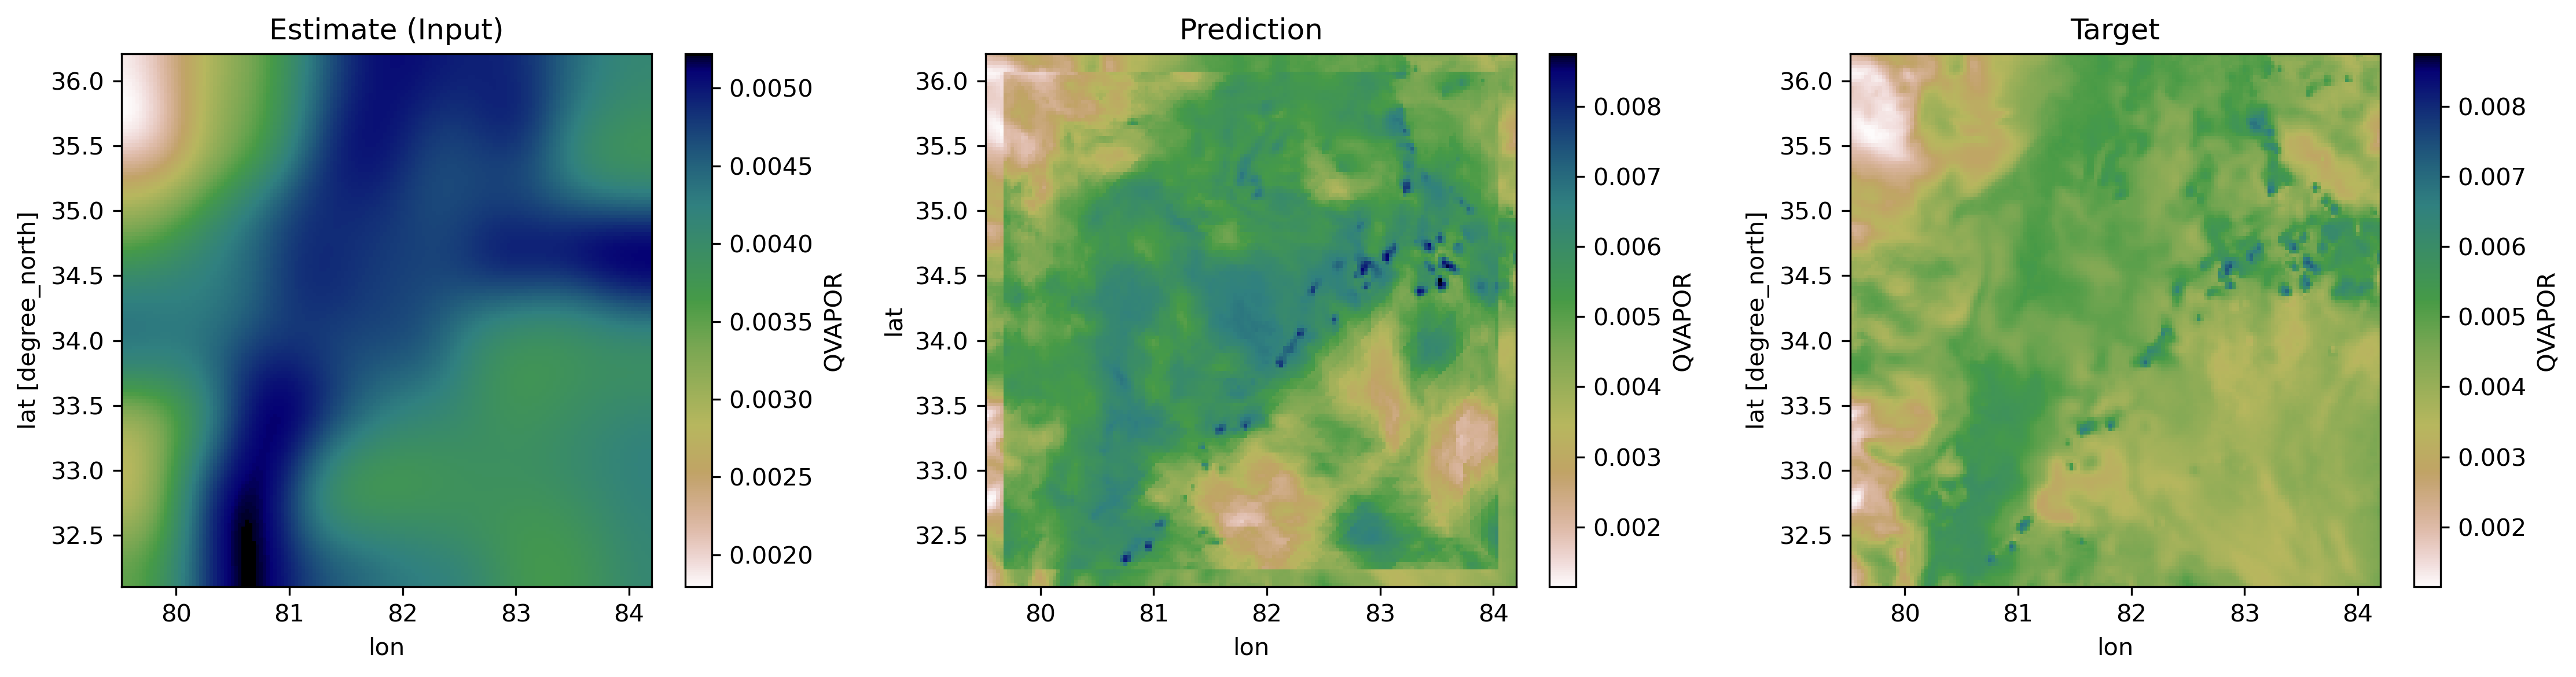

In [15]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

cmap = 'gist_earth_r'
var = 'QVAPOR'
level = 5

vmin = min(
           #inputs.isel(batch=0, time=0, level=level)[var].min().item(),
           predictions.isel(batch=0, time=0, level=level)[var].min().item(),
           targets.isel(batch=0, time=0, level=level)[var].min().item())

vmax = max(
           #inputs.isel(batch=0, time=0, level=level)[var].max().item(),
           predictions.isel(batch=0, time=0, level=level)[var].max().item(),
           targets.isel(batch=0, time=0, level=level)[var].max().item())


# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0, level=level)[var].plot(ax=axes[0], cmap=cmap)#, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0, level=level)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0, level=level)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (Input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()

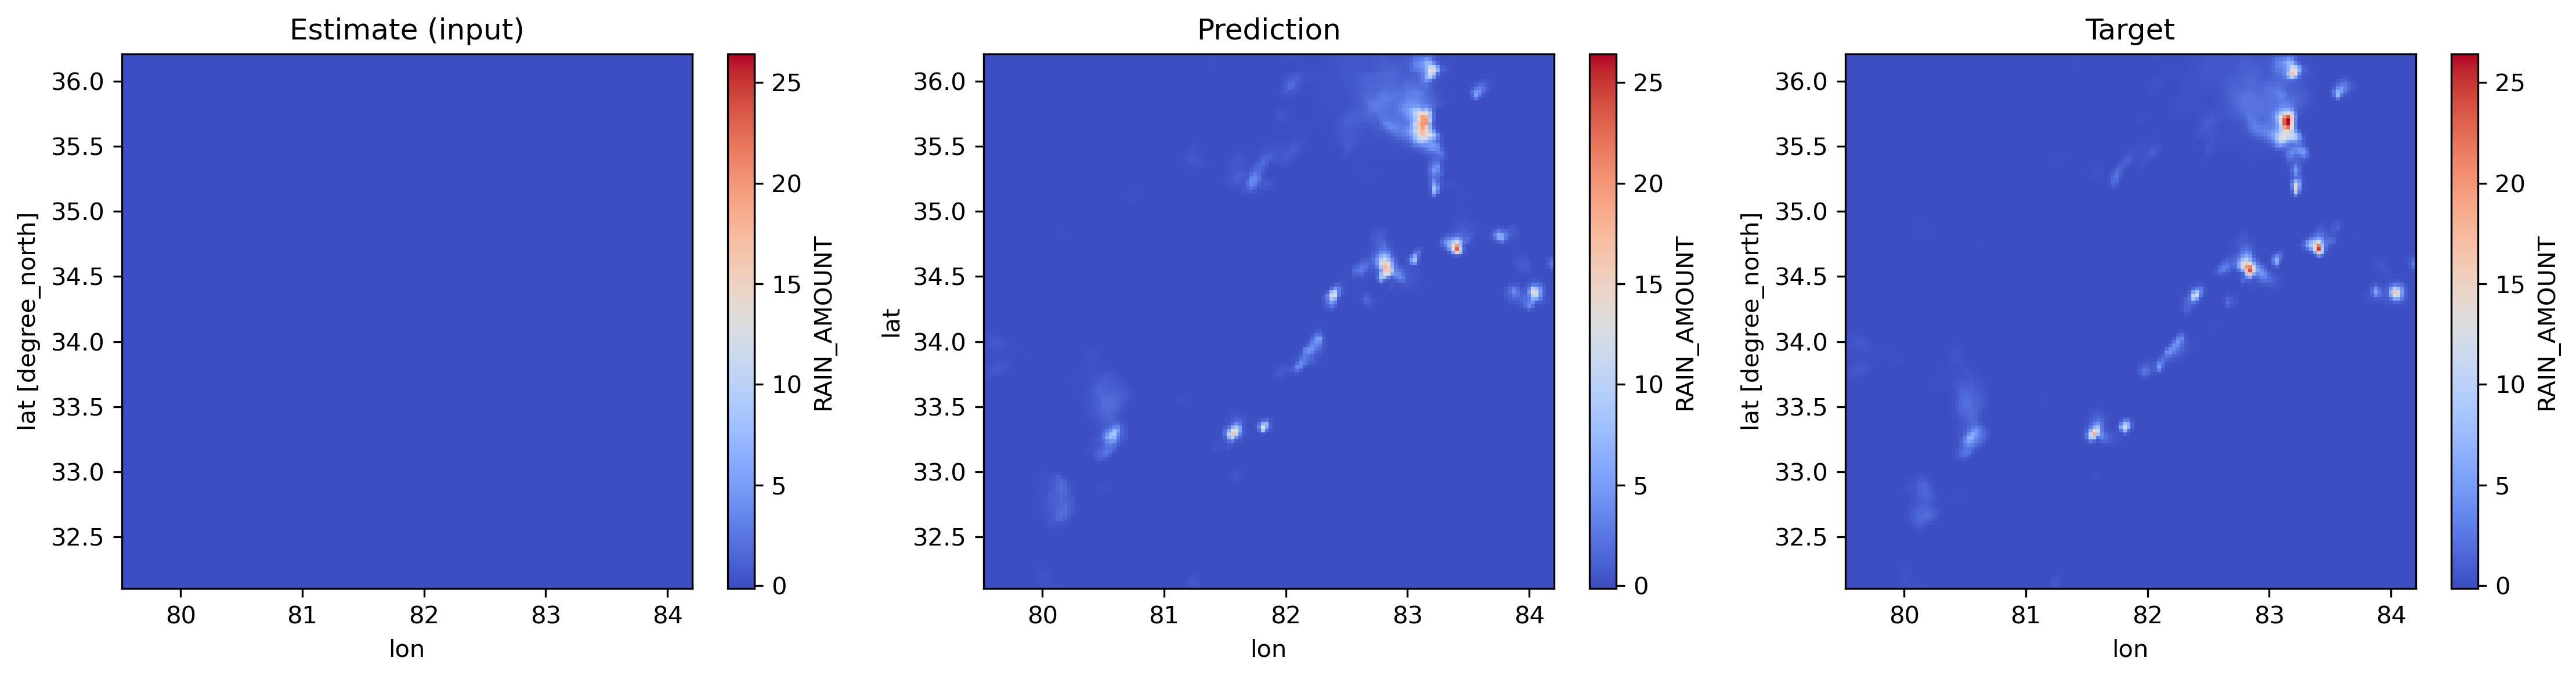

In [16]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

cmap = 'coolwarm'
var = 'RAIN_AMOUNT'

vmin = min(inputs.isel(batch=0, time=0)[var].min().item(),
           predictions.isel(batch=0, time=0)[var].min().item(),
           targets.isel(batch=0, time=0)[var].min().item())

vmax = max(inputs.isel(batch=0, time=0)[var].max().item(),
           predictions.isel(batch=0, time=0)[var].max().item(),
           targets.isel(batch=0, time=0)[var].max().item())

# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0)[var].plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()

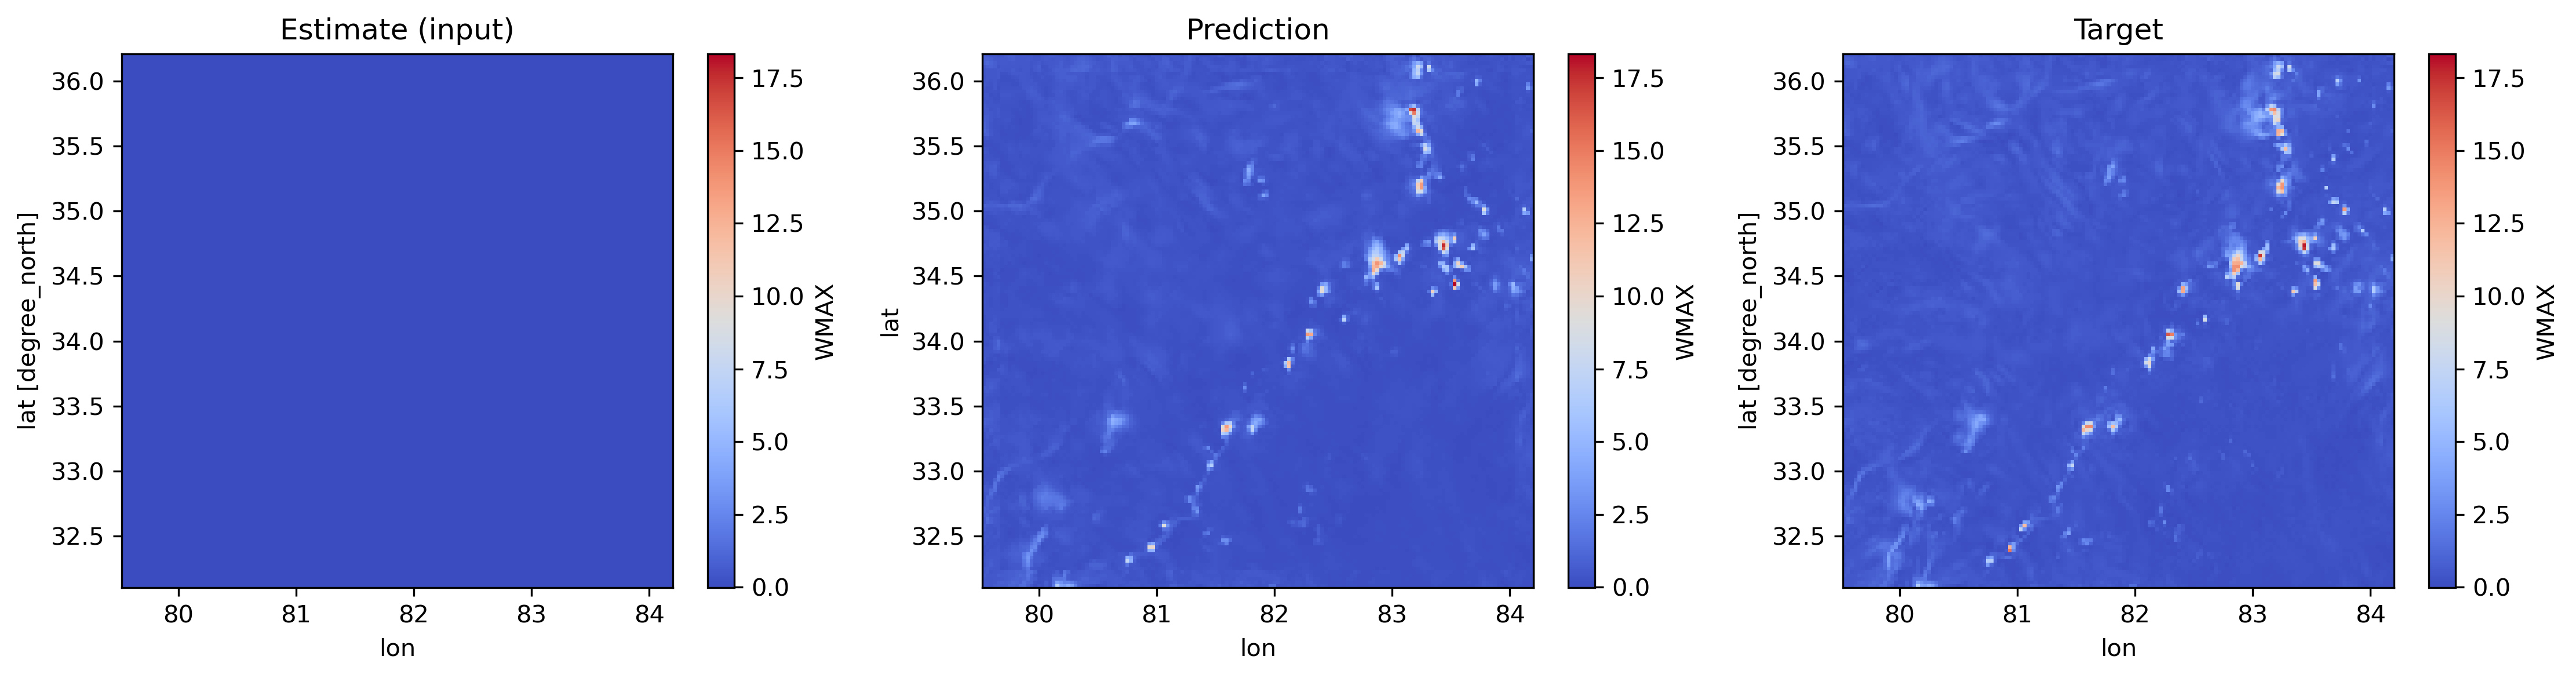

In [17]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

cmap = 'coolwarm'
var = 'WMAX'

vmin = min(inputs.isel(batch=0, time=0)[var].min().item(),
           predictions.isel(batch=0, time=0)[var].min().item(),
           targets.isel(batch=0, time=0)[var].min().item())

vmax = max(inputs.isel(batch=0, time=0)[var].max().item(),
           predictions.isel(batch=0, time=0)[var].max().item(),
           targets.isel(batch=0, time=0)[var].max().item())

# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0)[var].plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()

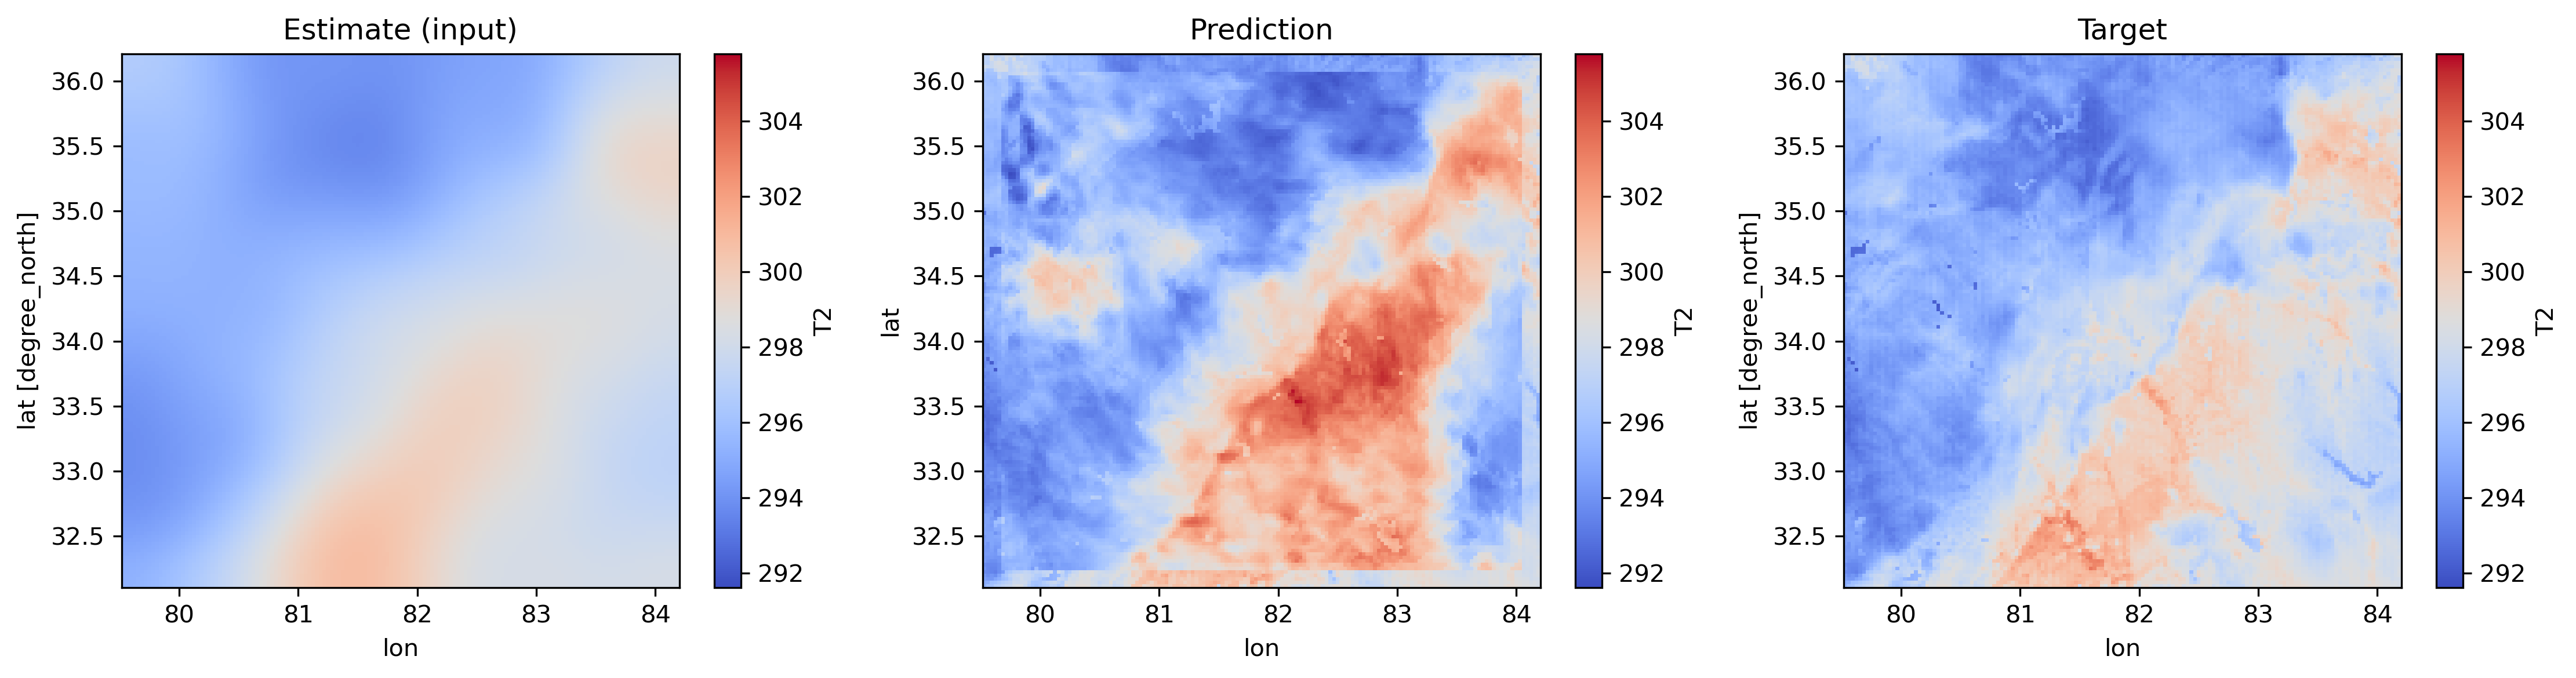

In [18]:
# Set up the plot
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(15,4))

cmap = 'coolwarm'
var = 'T2'

vmin = min(inputs.isel(batch=0, time=0)[var].min().item(),
           predictions.isel(batch=0, time=0)[var].min().item(),
           targets.isel(batch=0, time=0)[var].min().item())

vmax = max(inputs.isel(batch=0, time=0)[var].max().item(),
           predictions.isel(batch=0, time=0)[var].max().item(),
           targets.isel(batch=0, time=0)[var].max().item())

# Plot with shared vmin and vmax
inputs.isel(batch=0, time=0)[var].plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
predictions.isel(batch=0, time=0)[var].plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
targets.isel(batch=0, time=0)[var].plot(ax=axes[2], cmap=cmap, vmin=vmin, vmax=vmax)

# Set titles
titles = ['Estimate (input)', 'Prediction', 'Target']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

plt.tight_layout()